# Pose landmark detection guide

The MediaPipe Pose Landmarker task lets you detect landmarks of human bodies in an image or video. You can use this task to identify key body locations, analyze posture, and categorize movements. This task uses machine learning (ML) models that work with single images or video. The task outputs body pose landmarks in image coordinates and in 3-dimensional world coordinates.

## Task details

This section describes the capabilities, inputs, outputs, and configuration options of this task.

### Features

* Input image processing - Processing includes image rotation, resizing, normalization, and color space conversion.
* Score threshold - Filter results based on prediction scores.

| Task inputs | Task outputs |
| :--- | :--- |
| The Pose Landmarker accepts an input of one of the following data types:<br>- Still images<br>- Decoded video frames<br>- Live video feed | The Pose Landmarker outputs the following results:<br>- Pose landmarks in normalized image coordinates<br>- Pose landmarks in world coordinates<br>- Optional: a segmentation mask for the pose. |

### Configurations options

This task has the following configuration options:

| Option Name | Description | Value Range | Default Value |
| :--- | :--- | :--- | :--- |
| `running_mode` | Sets the running mode for the task. There are three modes:<br>IMAGE: The mode for single image inputs.<br>VIDEO: The mode for decoded frames of a video<br>LIVE_STREAM: The mode for a livestream of input data, such as from a camera. In this mode, resultListener must be called to set up a listener to receive results asynchronously. | `{IMAGE, VIDEO, LIVE_STREAM}` | `IMAGE` |
| `num_poses` | 	The maximum number of poses that can be detected by the Pose Landmarker. | `Integer > 0` | `1` |
| `min_pose_detection_confidence` | The minimum confidence score for the pose detection to be considered successful. | `Float [0.0,1.0]` | `0.5` |
| `min_pose_presence_confidence` | The minimum confidence score of pose presence score in the pose landmark detection. | `Float [0.0,1.0]` | `0.5` |
| `min_tracking_confidence` | The minimum confidence score for the pose tracking to be considered successful. | `Float [0.0,1.0]` | `0.5` |
| `output_segmentation_masks` | Whether Pose Landmarker outputs a segmentation mask for the detected pose. | `Boolean` | `False` |
| `result_callback` | Sets the result listener to receive the landmarker results asynchronously when Pose Landmarker is in the live stream mode. Can only be used when running mode is set to **LIVE_STREAM** | `ResultListener` | `N/A` |

## Models

The Pose Landmarker uses a series of models to predict pose landmarks. The first model detects the presence of human bodies within an image frame, and the second model locates landmarks on the bodies.

The following models are packaged together into a downloadable model bundle:

* **Pose detection model**: detects the presence of bodies with a few key pose landmarks.
* **Pose landmarker model**: adds a complete mapping of the pose. The model outputs an estimate of 33 3-dimensional pose landmarks.

This bundle uses a convolutional neural network similar to [MobileNetV2](https://arxiv.org/pdf/1801.04381.pdf) and is optimized for on-device, real-time fitness applications. This variant of the [BlazePose](https://arxiv.org/pdf/2006.10204.pdf) model uses [GHUM](https://openaccess.thecvf.com/content_CVPR_2020/papers/Xu_GHUM__GHUML_Generative_3D_Human_Shape_and_Articulated_Pose_CVPR_2020_paper.pdf), a 3D human shape modeling pipeline, to estimate the full 3D body pose of an individual in images or videos.

| Model bundle | Input shape | Data type | Model Cards | Versions |
| :--- | :--- | :--- | :--- | :--- |
| [Pose landmarker (lite)](https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_lite/float16/latest/pose_landmarker_lite.task) | Pose detector: 224 x 224 x 3<br>Pose landmarker: 256 x 256 x 3 | float 16 | [info](https://storage.googleapis.com/mediapipe-assets/Model%20Card%20BlazePose%20GHUM%203D.pdf) | [Latest](https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_lite/float16/latest/pose_landmarker_lite.task) |
| [Pose landmarker (Full)](https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_full/float16/latest/pose_landmarker_full.task) | Pose detector: 224 x 224 x 3<br>Pose landmarker: 256 x 256 x 3 | float 16 | [info](https://storage.googleapis.com/mediapipe-assets/Model%20Card%20BlazePose%20GHUM%203D.pdf) | [Latest](https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_full/float16/latest/pose_landmarker_full.task) |
| [Pose Landmarker (Heavy)](https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/latest/pose_landmarker_heavy.task) | Pose detector: 224 x 224 x 3<br>Pose landmarker: 256 x 256 x 3 | float 16 | [info](https://storage.googleapis.com/mediapipe-assets/Model%20Card%20BlazePose%20GHUM%203D.pdf) | [Latest](https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/latest/pose_landmarker_heavy.task) |

### Pose landmarker model

The pose landmarker model tracks 33 body landmark locations, representing the approximate location of the following body parts:

![Pose landmarker model](https://ai.google.dev/static/mediapipe/images/solutions/pose_landmarks_index.png)

```python
0 - nose
1 - left eye (inner)
2 - left eye
3 - left eye (outer)
4 - right eye (inner)
5 - right eye
6 - right eye (outer)
7 - left ear
8 - right ear
9 - mouth (left)
10 - mouth (right)
11 - left shoulder
12 - right shoulder
13 - left elbow
14 - right elbow
15 - left wrist
16 - right wrist
17 - left pinky
18 - right pinky
19 - left index
20 - right index
21 - left thumb
22 - right thumb
23 - left hip
24 - right hip
25 - left knee
26 - right knee
27 - left ankle
28 - right ankle
29 - left heel
30 - right heel
31 - left foot index
32 - right foot index
```

The model output contains both normalized coordinates (``Landmarks``) and world coordinates (``WorldLandmarks``) for each landmark.

## Preparation

Let's start with installing MediaPipe.

In [ ]:
# pip install -q mediapipe

Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker#models) for more information about this model bundle.

In [ ]:
# !curl -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

## Visualization utilities

In [2]:
import numpy as np
from mediapipe.tasks.python.vision import drawing_utils
from mediapipe.tasks.python.vision import drawing_styles
from mediapipe.tasks.python import vision


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  pose_landmark_style = drawing_styles.get_default_pose_landmarks_style()
  pose_connection_style = drawing_utils.DrawingSpec(color=(0, 255, 0), thickness=2)

  for pose_landmarks in pose_landmarks_list:
    drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=pose_landmarks,
        connections=vision.PoseLandmarksConnections.POSE_LANDMARKS,
        landmark_drawing_spec=pose_landmark_style,
        connection_drawing_spec=pose_connection_style)

  return annotated_image

Download test image
To demonstrate the Pose Landmarker API, you can download a sample image using the follow code. The image is from [Pixabay](https://www.google.com/url?q=https%3A%2F%2Fpixabay.com%2Fphotos%2Fgirl-woman-fitness-beautiful-smile-4051811%2F).

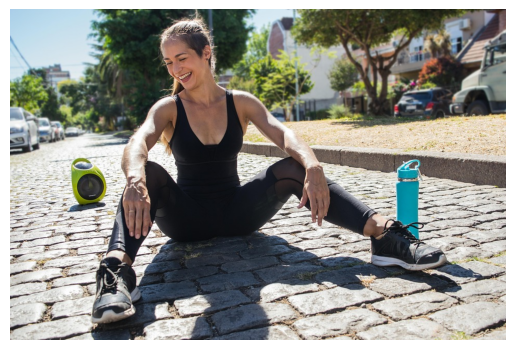

In [3]:
# !curl -q -O image.jpg https://cdn.pixabay.com/photo/2019/03/12/20/39/girl-4051811_960_720.jpg

import cv2
import matplotlib.pyplot as plt

# Resmi oku
img = cv2.imread('image1.jpg')
# OpenCV resimleri BGR formatında okur, Matplotlib ise RGB bekler.
# Renklerin doğru görünmesi için dönüştürme yapmalıyız:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Satır içi gösterim
plt.imshow(img_rgb)
plt.axis('off') # Eksenleri gizler
plt.show()

## Running inference and visualizing the results

The final step is to run pose landmark detection on your selected image. This involves creating your PoseLandmarker object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker/python) to learn more about configuration options that this solution supports.


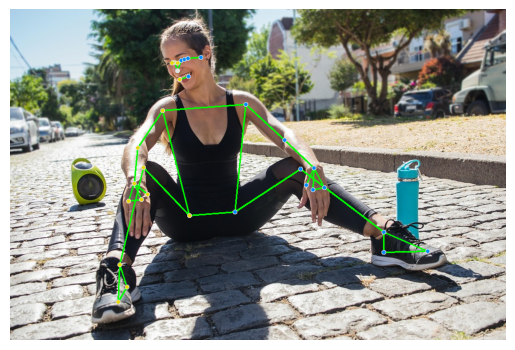

In [6]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker_heavy.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image1.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
# MediaPipe zaten RGB döndürdüğü için cv2.cvtColor yapmanıza gerek yok.
# Direkt görselleştirebiliriz:
plt.imshow(annotated_image)
plt.axis('off') # Koordinat eksenlerini gizler
plt.show()

Visualize the pose segmentation mask.

In [7]:
segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
segmentation_mask = np.squeeze(segmentation_mask)

# Convert to 3‑channel uint8 image for visualization.
visualized_mask = (segmentation_mask * 255).astype(np.uint8)
visualized_mask = np.stack([visualized_mask]*3, axis=-1)